# Experiment for NFL Data

## Data Preparation

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data_filepath = "./pbp-2016.csv"

In [6]:
df = pd.read_csv(data_filepath)

In [7]:
df.columns

Index(['GameId', 'GameDate', 'Quarter', 'Minute', 'Second', 'OffenseTeam',
       'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'Unnamed: 10',
       'SeriesFirstDown', 'Unnamed: 12', 'NextScore', 'Description', 'TeamWin',
       'Unnamed: 16', 'Unnamed: 17', 'SeasonYear', 'Yards', 'Formation',
       'PlayType', 'IsRush', 'IsPass', 'IsIncomplete', 'IsTouchdown',
       'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed',
       'Challenger', 'IsMeasurement', 'IsInterception', 'IsFumble',
       'IsPenalty', 'IsTwoPointConversion', 'IsTwoPointConversionSuccessful',
       'RushDirection', 'YardLineFixed', 'YardLineDirection',
       'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay', 'PenaltyType',
       'PenaltyYards'],
      dtype='object')

In [8]:
features_to_use = ['Quarter', 'Minute', 'Second', 'OffenseTeam', 'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'Formation', 'PlayType', 'IsRush', 'IsPass', 'Yards', 'PassType', 'RushDirection']


In [9]:
df = df[features_to_use]



In [10]:
df = df.loc[df['Down'] == 3]

In [11]:
df

,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Formation,PlayType,IsRush,IsPass,Yards,PassType,RushDirection
16,2,1,26,NO,OAK,3,4,53,SHOTGUN,PASS,0,1,0,DEEP LEFT,NaN
33,1,13,46,PHI,CLE,3,3,32,SHOTGUN,NO PLAY,0,0,0,NaN,NaN
40,2,12,53,MIN,TEN,3,24,75,UNDER CENTER,RUSH,1,0,6,NaN,LEFT END
42,2,2,29,TEN,MIN,3,1,54,NO HUDDLE SHOTGUN,PASS,0,1,16,SHORT LEFT,NaN
48,2,6,59,OAK,CAR,3,5,95,SHOTGUN,PASS,0,1,0,SHORT MIDDLE,NaN
61,2,2,11,NYJ,NE,3,4,64,SHOTGUN,PASS,0,1,0,DEEP LEFT,NaN
65,2,0,40,NE,NYJ,3,2,65,UNDER CENTER,PASS,0,1,14,SHORT RIGHT,NaN
67,1,5,56,SEA,MIA,3,9,84,SHOTGUN,SACK,0,0,-5,NaN,NaN
81,2,11,55,SF,CAR,3,11,40,SHOTGUN,PASS,0,1,13,SHORT MIDDLE,NaN
94,1,13,42,CLE,BAL,3,7,28,SHOTGUN,PASS,0,1,8,SHORT RIGHT,NaN


In [12]:
df['PlayType'].unique


<bound method Series.unique of 16           PASS
33        NO PLAY
40           RUSH
42           PASS
48           PASS
61           PASS
65           PASS
67           SACK
81           PASS
94           PASS
101          PASS
106          PASS
107          PASS
111      SCRAMBLE
112          PASS
117      SCRAMBLE
122          PASS
138          PASS
159          PASS
183          RUSH
192          SACK
202          PASS
204          PASS
209          PASS
216       NO PLAY
217          PASS
220          PASS
229          PASS
236          PASS
242          RUSH
           ...   
45784        PASS
45792        RUSH
45796        RUSH
45802        RUSH
45812        PASS
45830        PASS
45833        RUSH
45837        PASS
45841        PASS
45849        RUSH
45850        PASS
45854        PASS
45862        PASS
45869        PASS
45876        SACK
45886        PASS
45891        SACK
45897        RUSH
45902        PASS
45910        RUSH
45911        PASS
45917        PASS
45921        PA

In [13]:
df = df.loc[df['PlayType'].isin(['PASS', 'RUSH', 'SCRAMBLE'])]

In [14]:
df['Conversion'] = df['Yards'] >= df['ToGo']


/home/sirjan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
df

,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Formation,PlayType,IsRush,IsPass,Yards,PassType,RushDirection,Conversion
16,2,1,26,NO,OAK,3,4,53,SHOTGUN,PASS,0,1,0,DEEP LEFT,NaN,False
40,2,12,53,MIN,TEN,3,24,75,UNDER CENTER,RUSH,1,0,6,NaN,LEFT END,False
42,2,2,29,TEN,MIN,3,1,54,NO HUDDLE SHOTGUN,PASS,0,1,16,SHORT LEFT,NaN,True
48,2,6,59,OAK,CAR,3,5,95,SHOTGUN,PASS,0,1,0,SHORT MIDDLE,NaN,False
61,2,2,11,NYJ,NE,3,4,64,SHOTGUN,PASS,0,1,0,DEEP LEFT,NaN,False
65,2,0,40,NE,NYJ,3,2,65,UNDER CENTER,PASS,0,1,14,SHORT RIGHT,NaN,True
81,2,11,55,SF,CAR,3,11,40,SHOTGUN,PASS,0,1,13,SHORT MIDDLE,NaN,True
94,1,13,42,CLE,BAL,3,7,28,SHOTGUN,PASS,0,1,8,SHORT RIGHT,NaN,True
101,4,3,30,NE,NYJ,3,10,57,SHOTGUN,PASS,0,1,6,SHORT RIGHT,NaN,False
106,4,8,50,CLE,BAL,3,19,35,SHOTGUN,PASS,0,1,25,DEEP RIGHT,NaN,True


In [16]:
df.values


array([[2, 1, 26, ..., 'DEEP LEFT', nan, False],
       [2, 12, 53, ..., nan, 'LEFT END', False],
       [2, 2, 29, ..., 'SHORT LEFT', nan, True],
       ..., 
       [1, 1, 18, ..., 'SHORT LEFT', nan, False],
       [3, 7, 1, ..., 'SHORT RIGHT', nan, True],
       [3, 4, 24, ..., nan, nan, False]], dtype=object)

In [17]:
raw_matrix = df.values

In [18]:
set(df['Formation'])

{'NO HUDDLE', 'NO HUDDLE SHOTGUN', 'SHOTGUN', 'UNDER CENTER'}

In [19]:
set(df['PassType'])

{nan,
 'DEEP LEFT',
 'SHORT MIDDLE',
 'SHORT LEFT',
 'DEEP MIDDLE',
 'DEEP RIGHT',
 'NOT LISTED',
 'INTENDED FOR',
 'RIGHT. PENALTY',
 'SHORT RIGHT',
 '(6:41) (SHOTGUN)'}

In [20]:
df.loc[df['PassType'] == '(6:41) (SHOTGUN)']

,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Formation,PlayType,IsRush,IsPass,Yards,PassType,RushDirection,Conversion
9829,1,6,41,NO,OAK,3,8,89,SHOTGUN,PASS,0,1,0,(6:41) (SHOTGUN),NaN,False


In [21]:
df = df.loc[df['PassType'] != '(6:41) (SHOTGUN)']

In [22]:
df


,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Formation,PlayType,IsRush,IsPass,Yards,PassType,RushDirection,Conversion
16,2,1,26,NO,OAK,3,4,53,SHOTGUN,PASS,0,1,0,DEEP LEFT,NaN,False
40,2,12,53,MIN,TEN,3,24,75,UNDER CENTER,RUSH,1,0,6,NaN,LEFT END,False
42,2,2,29,TEN,MIN,3,1,54,NO HUDDLE SHOTGUN,PASS,0,1,16,SHORT LEFT,NaN,True
48,2,6,59,OAK,CAR,3,5,95,SHOTGUN,PASS,0,1,0,SHORT MIDDLE,NaN,False
61,2,2,11,NYJ,NE,3,4,64,SHOTGUN,PASS,0,1,0,DEEP LEFT,NaN,False
65,2,0,40,NE,NYJ,3,2,65,UNDER CENTER,PASS,0,1,14,SHORT RIGHT,NaN,True
81,2,11,55,SF,CAR,3,11,40,SHOTGUN,PASS,0,1,13,SHORT MIDDLE,NaN,True
94,1,13,42,CLE,BAL,3,7,28,SHOTGUN,PASS,0,1,8,SHORT RIGHT,NaN,True
101,4,3,30,NE,NYJ,3,10,57,SHOTGUN,PASS,0,1,6,SHORT RIGHT,NaN,False
106,4,8,50,CLE,BAL,3,19,35,SHOTGUN,PASS,0,1,25,DEEP RIGHT,NaN,True


In [23]:
set(df['PassType'])

{nan,
 'DEEP LEFT',
 'SHORT MIDDLE',
 'SHORT LEFT',
 'DEEP MIDDLE',
 'DEEP RIGHT',
 'NOT LISTED',
 'INTENDED FOR',
 'RIGHT. PENALTY',
 'SHORT RIGHT'}

In [24]:
df.loc[df['PassType'] == 'RIGHT. PENALTY']

,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Formation,PlayType,IsRush,IsPass,Yards,PassType,RushDirection,Conversion
38471,1,13,36,NO,DET,3,1,27,SHOTGUN,PASS,0,1,-4,RIGHT. PENALTY,NaN,False


In [25]:
df = df.loc[df['PassType'] != 'RIGHT. PENALTY']

In [26]:
df

,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Formation,PlayType,IsRush,IsPass,Yards,PassType,RushDirection,Conversion
16,2,1,26,NO,OAK,3,4,53,SHOTGUN,PASS,0,1,0,DEEP LEFT,NaN,False
40,2,12,53,MIN,TEN,3,24,75,UNDER CENTER,RUSH,1,0,6,NaN,LEFT END,False
42,2,2,29,TEN,MIN,3,1,54,NO HUDDLE SHOTGUN,PASS,0,1,16,SHORT LEFT,NaN,True
48,2,6,59,OAK,CAR,3,5,95,SHOTGUN,PASS,0,1,0,SHORT MIDDLE,NaN,False
61,2,2,11,NYJ,NE,3,4,64,SHOTGUN,PASS,0,1,0,DEEP LEFT,NaN,False
65,2,0,40,NE,NYJ,3,2,65,UNDER CENTER,PASS,0,1,14,SHORT RIGHT,NaN,True
81,2,11,55,SF,CAR,3,11,40,SHOTGUN,PASS,0,1,13,SHORT MIDDLE,NaN,True
94,1,13,42,CLE,BAL,3,7,28,SHOTGUN,PASS,0,1,8,SHORT RIGHT,NaN,True
101,4,3,30,NE,NYJ,3,10,57,SHOTGUN,PASS,0,1,6,SHORT RIGHT,NaN,False
106,4,8,50,CLE,BAL,3,19,35,SHOTGUN,PASS,0,1,25,DEEP RIGHT,NaN,True


In [27]:
df = df.loc[df['PassType'] != 'INTENDED FOR']

In [28]:
df = df.loc[df['PassType'] != 'NOT LISTED']

In [29]:
set(df['PassType'])

{nan,
 'DEEP LEFT',
 'SHORT MIDDLE',
 'SHORT LEFT',
 'DEEP MIDDLE',
 'DEEP RIGHT',
 'SHORT RIGHT'}

In [30]:
set(df['RushDirection'])

{nan,
 'LEFT TACKLE',
 'LEFT GUARD',
 'RIGHT GUARD',
 'LEFT END',
 'CENTER',
 'RIGHT END',
 'RIGHT TACKLE'}

In [31]:
def one_hot_feature(df, feat):
    n_elem = len(set(df[feat]))
    one_hot_dict = dict()
    distinct_features = set(df[feat])
    counter = 0
    for feature in distinct_features:
        feature_vector = [0] * n_elem
        feature_vector[counter] = 1
        one_hot_dict[feature] = feature_vector
        counter += 1
    return one_hot_dict

In [32]:
one_hot_feature(df, 'Formation')

{'NO HUDDLE': [0, 0, 0, 1],
 'NO HUDDLE SHOTGUN': [0, 0, 1, 0],
 'SHOTGUN': [0, 1, 0, 0],
 'UNDER CENTER': [1, 0, 0, 0]}

In [33]:
def one_hot_from_list(feature_list):
    n_elem = len(feature_list)
    one_hot_dict = dict()
    counter = 0
    for feature in feature_list:
        feature_vector = [0] * n_elem
        feature_vector[counter] = 1
        one_hot_dict[feature] = feature_vector
        counter += 1
    return one_hot_dict

In [34]:
df.columns

Index(['Quarter', 'Minute', 'Second', 'OffenseTeam', 'DefenseTeam', 'Down',
       'ToGo', 'YardLine', 'Formation', 'PlayType', 'IsRush', 'IsPass',
       'Yards', 'PassType', 'RushDirection', 'Conversion'],
      dtype='object')

In [35]:
formation_dict = one_hot_feature(df, 'Formation')
team_dict = one_hot_feature(df, 'OffenseTeam')
play_types = set(df['PassType']).union(set(df['RushDirection']))
play_types = list(play_types)
play_types.append('SCRAMBLE')
play_types.pop(0)
play_type_dict = one_hot_from_list(play_types)

In [36]:
def df_series_to_feature_vec(df_series):
    feature_list = []
    feature_list.append(df_series['Quarter'])
    feature_list.append(df_series['Minute'])
    feature_list.append(df_series['Second'])
    feature_list += team_dict[df_series['OffenseTeam']]
    feature_list += team_dict[df_series['DefenseTeam']]
    feature_list.append(df_series['Down'])
    feature_list.append(df_series['ToGo'])
    feature_list.append(df_series['YardLine'])
    feature_list += formation_dict[df_series['Formation']]
    if df_series['PlayType'] == 'SCRAMBLE':
        play_type = 'SCRAMBLE'
    elif type(df_series['PassType']) == str:
        play_type = df_series['PassType']
    elif type(df_series['RushDirection']) == str:
        play_type = df_series['RushDirection']
    else:
        return None
    feature_list += play_type_dict[play_type]
    return np.array(feature_list)

In [37]:
df.iloc[0]

Quarter                  2
Minute                   1
Second                  26
OffenseTeam             NO
DefenseTeam            OAK
Down                     3
ToGo                     4
YardLine                53
Formation          SHOTGUN
PlayType              PASS
IsRush                   0
IsPass                   1
Yards                    0
PassType         DEEP LEFT
RushDirection          NaN
Conversion           False
Name: 16, dtype: object

In [38]:
df_series_to_feature_vec(df.iloc[0])

array([ 2,  1, 26,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,
        4, 53,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [39]:
data_mat = []
labels = []
for i in range(len(df)):
    df_series = df.iloc[i]
    feature_vec = df_series_to_feature_vec(df_series)
    if feature_vec is None:
        continue
    data_mat.append(feature_vec)
    labels.append(df_series['Conversion'])

In [40]:
len(data_mat)

6561

In [41]:
len(labels)

6561

In [42]:
data_mat = np.array(data_mat)
labels = np.array(labels)

In [43]:
data_mat.shape

(6561, 88)

In [44]:
np.savetxt('nfl_2016_feature_vec_vers1.csv', data_mat)
np.savetxt('nfl_2016_labels_vers1.csv', labels)

## Model Training & Validation

In [68]:
data_mat = np.loadtxt('nfl_2016_feature_vec_vers1.csv')
labels = np.loadtxt('nfl_2016_labels_vers1.csv')

In [69]:
print(data_mat.shape)
print(labels.shape)

(6561, 88)
(6561,)


In [70]:
## Take the SVD
# from scipy.sparse.linalg import svds
# u, s, vt = svds(data_mat, 20)

In [71]:
from math import isnan
for l in data_mat:
    for elem in l:
        if isnan(elem):
            print('rip')

In [105]:
class BortlesModel:
    def __init__(self, input_dimension, learning_rate=0.5, decay_steps=None, decay_rate=None):
        self.weight_path = 'bortles_weights.csv'
        self.bias_path = 'bortles_bias.csv'
        self.construct_model(input_dimension, learning_rate, decay_steps, decay_rate)
    
    def construct_model(self, input_dimension, starter_learning_rate, decay_steps, decay_rate):
        self.input_data = tf.placeholder(tf.float32, (None, input_dimension))
        self.labels = tf.placeholder(tf.int32, (None,))
        self.weights = tf.Variable(tf.random_normal((input_dimension, 2)))
        self.bias = tf.Variable(tf.random_normal((2,)))
        
        self.output = tf.matmul(self.input_data, self.weights) + self.bias

        # Cross Entropy
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.labels, logits=self.output))
        
        if decay_steps and decay_rate:
            global_step = tf.Variable(0, trainable=False)
            learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                       decay_steps, decay_rate, staircase=True)
            # Passing global_step to minimize() will increment it at each step.
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.cost, global_step=global_step)
        else:
            self.optimizer = tf.train.GradientDescentOptimizer(starter_learning_rate).minimize(self.cost)
    
    def train_model(self, train_data, train_labels, num_iter=1000, use_stored_params=False):
        if use_stored_params:
            weights = np.loadtxt(self.weight_path)
            bias = np.loadtxt(self.bias_path)
            tf.assign(self.weights, weights)
            tf.assign(self.bias, bias)
        init = tf.global_variables_initializer()
        losses = []
        
        with tf.Session() as sess:
            # Initialize the variables.
            sess.run(init)
            
            for i in range(num_iter):
                _, loss_val = sess.run([self.optimizer, self.cost], feed_dict={self.input_data: train_data, self.labels: train_labels})
                if i % 100 == 0:
                    print(i)
                    print(loss_val)
                    losses.append(loss_val)
            
            weights = sess.run(self.weights)
            bias = sess.run(self.bias)
        
        return np.array(losses), weights, bias
    
    def apply_model(self, weights, bias, data, labels):
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            
            logits = sess.run(self.output, feed_dict={self.input_data: data, self.labels: labels, self.weights: weights, self.bias: bias})
            pred_labels = sess.run(tf.argmax(logits, 1))
        
        return pred_labels
    
    def store_weights_and_bias(self, weights, bias):
        np.savetxt(self.weight_path, weights)
        np.savetxt(self.bias_path, bias)

In [111]:
bortles = BortlesModel(input_dimension=data_mat.shape[1], learning_rate=0.02, decay_steps=200, decay_rate=0.96)

In [112]:
loss, weights, bias = bortles.train_model(data_mat, labels, num_iter=20000)

0
39.3125
100
5.18789
200
7.25963
300
6.49461
400
6.49661
500
6.82175
600
7.10518
700
7.2517
800
7.38385
900
7.37674
1000
7.40179
1100
7.29244
1200
7.25747
1300
7.09575
1400
7.03348
1500
6.85044
1600
6.77862
1700
6.59088
1800
6.5178
1900
6.33229
2000
6.26121
2100
6.08034
2200
6.01245
2300
5.83707
2400
5.77279
2500
5.60328
2600
5.54273
2700
5.37922
2800
5.32239
2900
5.16482
3000
5.11166
3100
4.95989
3200
4.91029
3300
4.76405
3400
4.71787
3500
4.57682
3600
4.53385
3700
4.39757
3800
4.35764
3900
4.22574
4000
4.18866
4100
4.06083
4200
4.02648
4300
3.90251
4400
3.87077
4500
3.75052
4600
3.72133
4700
3.6047
4800
3.57799
4900
3.46487
5000
3.44056
5100
3.33086
5200
3.30884
5300
3.20243
5400
3.18261
5500
3.07947
5600
3.06172
5700
2.96185
5800
2.94605
5900
2.84951
6000
2.83553
6100
2.74235
6200
2.73007
6300
2.64025
6400
2.62955
6500
2.54304
6600
2.53379
6700
2.45044
6800
2.44254
6900
2.36213
7000
2.35548
7100
2.27773
7200
2.27226
7300
2.19685
7400
2.19247
7500
2.1191
7600
2.11576
7700
2.04411
78

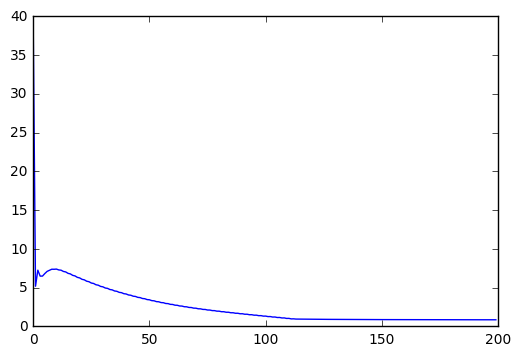

In [113]:
plt.plot(loss)

In [ ]:
# Store model weights
bortles.store_weights_and_bias(weights, bias)

In [ ]:
### ONLY RUN IF weights and bias stored from previous run
loss, weights, bias = bortles.train_model(data_mat, labels, num_iter=200, use_stored_params=True)

In [114]:
# Apply model and see training error
pred_labels = bortles.apply_model(data=data_mat, labels=labels, weights=weights, bias=bias)

In [115]:
# See training error
num_match = 0
for i in range(len(labels)):
    if labels[i] == pred_labels[i]:
        num_match += 1

print('Training Error:', num_match / len(labels))

Training Error: 0.59564090839811


### Simulated stuff

In [52]:
# Test on simulated data.
feature_vecs = np.random.uniform(size=(6000, 90))

In [53]:
labels = []
for i in range(len(feature_vecs)):
    s = 0.4 * sum(feature_vecs[i])
    if s > 18.5:
        lab = 1
    else:
        lab = 0
    labels.append(lab)
labels = np.array(labels)
print(len(labels))
print(sum(labels))

6000
1994


In [54]:
bortles_sim = BortlesModel(input_dimension=90, learning_rate=0.1)

In [55]:
losses, weights, bias = bortles_sim.train_model(train_data=feature_vecs, train_labels=labels, num_iter=5000)

0
2.72577
100
1.34433
200
1.16439
300
1.00389
400
0.866771
500
0.756261
600
0.67333
700
0.61553
800
0.577507
900
0.55304
1000
0.536919
1100
0.525598
1200
0.51695
1300
0.50979
1400
0.503483
1500
0.497691
1600
0.492239
1700
0.48703
1800
0.482014
1900
0.47716
2000
0.472452
2100
0.467877
2200
0.463428
2300
0.459097
2400
0.454881
2500
0.450773
2600
0.446771
2700
0.442868
2800
0.439064
2900
0.435352
3000
0.431731
3100
0.428198
3200
0.424748
3300
0.421379
3400
0.418089
3500
0.414873
3600
0.411732
3700
0.40866
3800
0.405657
3900
0.402721
4000
0.399847
4100
0.397036
4200
0.394284
4300
0.39159
4400
0.388952
4500
0.386369
4600
0.383837
4700
0.381357
4800
0.378926
4900
0.376543


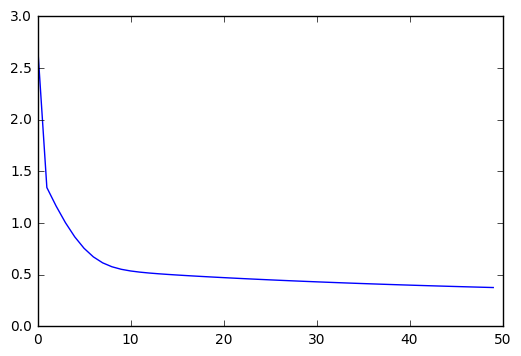

In [92]:
plt.plot(losses[0:-1:100])

In [93]:
print(weights)

[[-1.37363708 -1.21251976]
 [-0.36803618  0.31406298]
 [-1.45124578 -1.52446342]
 [-1.3890332   2.0580945 ]
 [-0.52084213  1.46847391]
 [ 1.10552704  0.64853036]
 [-0.33386007 -0.91984308]
 [ 1.08505619  0.49500376]
 [ 0.12865837  0.75650543]
 [ 0.05258742 -1.61262298]
 [ 0.02723498 -1.10206509]
 [-1.37949371  0.41938776]
 [-0.46241158 -0.49266836]
 [-0.83137101 -2.2035358 ]
 [-0.36930177  1.81903124]
 [ 0.05664659 -0.61344749]
 [ 1.19590926 -1.24000645]
 [-0.73953211 -0.15176776]
 [ 0.35456866 -1.0127008 ]
 [-0.07292411  3.33025599]
 [-2.67960143  0.04275904]
 [ 0.84500611 -0.53907704]
 [ 1.46765018  0.79293734]
 [ 0.73660207  0.42860591]
 [-0.1274163   0.4083851 ]
 [ 0.02404692 -1.10372257]
 [ 0.59165609  0.96974897]
 [-0.06653068 -1.95155811]
 [-0.39821875  0.22340874]
 [-0.60876513  1.37013292]
 [ 1.0161587   1.7935338 ]
 [ 0.1960299   0.01916892]
 [ 3.27570224 -1.01383221]
 [ 0.63732076  1.74287152]
 [-0.22476286  1.6584326 ]
 [ 1.93120027  1.38418591]
 [ 0.55123538 -0.40553087]
 

In [58]:
print(bias)

[ 8.7156105  -7.68937588]


In [61]:
pred_labels = bortles_sim.apply_model(bias=bias, weights=weights, data=feature_vecs, labels=labels)

In [63]:
num_correct = 0
for i in range(len(labels)):
    if labels[i] == pred_labels[i]:
        num_correct += 1
print('training accuracy:', num_correct / len(labels))

training accuracy: 0.8885


1904